# Rain Prediction Problem
Rain Dataset: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

Purpose: Given information about previous weather conditions in Australia, predict whether it will rain the next day given current weather conditions.

In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

<h2>1. Import Dataset</h2>

In [2]:
data = pd.read_csv('./datasets/RAIN/weatherAUS.csv')
data.head() #Data preview

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [3]:
#manually drop columns (becuase they are unecessary or have a lot of NAN values)
data = data.drop("Date", axis=1)
data = data.drop("Location", axis=1)
data = data.drop("Evaporation", axis=1)
data = data.drop("Sunshine", axis=1)
data = data.drop("WindGustDir", axis=1)
data = data.drop("WindDir9am", axis=1)
data = data.drop("WindDir3pm", axis=1)
data = data.drop("Cloud9am", axis=1)
data = data.drop("Cloud3pm", axis=1)
data = data.drop("RISK_MM", axis=1)
data.head()#Data preview

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No


In [4]:
#Checking what data types we have in the dataset
print(data.dtypes)
#Result shows that they are floats or strings

#Check for any NULL values in the dataset
remove = data[data.isnull().any(axis=1)]
#Drop samples with any NULL values
data = data.drop(remove.index, axis=0)
#Result shows that there are some NULL values
data.head()

MinTemp          float64
MaxTemp          float64
Rainfall         float64
WindGustSpeed    float64
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object


,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No


In [5]:
#Encoding using SKlearn's label encoder function for string (binary) features
lb_Make = LabelEncoder()
data["RainToday"] = lb_Make.fit_transform(data["RainToday"])
data["RainTomorrow"] = lb_Make.fit_transform(data["RainTomorrow"])
print(data.shape)
data.head()

(119590, 14)


,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0,0
1,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0,0
2,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0,0
3,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0,0
4,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0,0


In [6]:
#Use only 10,000 random samples
data = data.sample(n=10000).reset_index(drop=True)
#Convert Data to a numpy Array
data = data.values
print(data[0:5])#Preview

[[1.1300e+01 2.3700e+01 2.0000e-01 2.6000e+01 7.0000e+00 1.1000e+01
  4.4000e+01 2.5000e+01 1.0169e+03 1.0130e+03 1.7800e+01 2.2900e+01
  0.0000e+00 0.0000e+00]
 [1.3500e+01 2.3700e+01 0.0000e+00 4.3000e+01 2.0000e+01 2.4000e+01
  5.1000e+01 4.3000e+01 1.0113e+03 1.0129e+03 2.0000e+01 2.3300e+01
  0.0000e+00 0.0000e+00]
 [9.9000e+00 2.0900e+01 0.0000e+00 3.9000e+01 1.3000e+01 2.2000e+01
  5.4000e+01 4.4000e+01 1.0237e+03 1.0213e+03 1.4800e+01 1.9300e+01
  0.0000e+00 0.0000e+00]
 [1.3100e+01 2.4200e+01 8.0000e-01 3.5000e+01 2.0000e+00 1.7000e+01
  9.4000e+01 6.5000e+01 1.0215e+03 1.0170e+03 1.6100e+01 2.1700e+01
  0.0000e+00 0.0000e+00]
 [8.0000e+00 1.7800e+01 1.0000e+00 4.8000e+01 1.7000e+01 3.0000e+01
  8.8000e+01 5.8000e+01 1.0209e+03 1.0175e+03 1.1100e+01 1.6400e+01
  0.0000e+00 0.0000e+00]]


<h2>2. Declare classifier functions</h2>

In [7]:
global count 
count = 0
def draw_heatmap(acc, acc_desc, C_list, character):
    global count
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=C_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$'  + character + '$')
    plt.title(acc_desc + ' w.r.t $' + character + '$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    count+=1

In [8]:
def svm_func():
    #SVM binary classification
    classifier = svm.SVC(kernel = 'linear')
    C_list     = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1] # Different C to try.
    parameters = {'C': C_list}
    clf = GridSearchCV(classifier, parameters, return_train_score = 'true', cv=5)#Perform a grid Search to identify the best C
    clf.fit(X_train_val, Y_train_val)#fit the classifier with the training data

    #Extract the training and validation accuracies and plot them as heat maps tovisualize the best C parameter
    train_acc = clf.cv_results_['mean_train_score']
    draw_heatmap(train_acc.reshape(-1,1), 'train accuracy', C_list, 'C')

    val_acc = clf.cv_results_['mean_test_score']
    draw_heatmap(val_acc.reshape(-1,1), 'val accuracy', C_list, 'C')

    #Find the optimal C parameter and use that to redefine the classifier
    optimal_classifier = svm.SVC(kernel = 'linear', C = clf.best_params_['C'] )
    
    for i,j in enumerate(C_list):
        if j == clf.best_params_['C']:
            best_train_acc = train_acc[i]
            
    #Find test accuracy
    optimal_classifier.fit(X_train_val, Y_train_val)
    test_acc = optimal_classifier.score(X_test, Y_test)
    return test_acc, best_train_acc, clf.best_params_['C']

In [9]:
def svm_func_boost():
    classifier = svm.SVC(kernel = 'linear')
    C_list     = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1] # Different C to try.
    parameters = {'C': C_list}
    clf = GridSearchCV(classifier, parameters, return_train_score = 'true', cv=5)#Perform a grid Search to identify the best C
    clf.fit(X_train_val, Y_train_val)#fit the classifier with the training data
    train_acc = clf.cv_results_['mean_train_score']
    optimal_classifier = svm.SVC(kernel = 'linear', C = clf.best_params_['C'] )
    
    boostedSVM = AdaBoostClassifier(optimal_classifier, algorithm = "SAMME")
    boostedSVM.fit(X_train_val, Y_train_val)
    test_acc = boostedSVM.score(X_test,Y_test)
    
    for i,j in enumerate(C_list):
        if j == clf.best_params_['C']:
            best_train_acc = train_acc[i]
    
    return test_acc, best_train_acc, clf.best_params_['C']

In [10]:
def decision_Tree():
    #Decision Tree Classifier
    D_list = np.array([1, 2, 3, 4, 5])
    parameters = {'max_depth':D_list}
    classifier_grid = GridSearchCV(DecisionTreeClassifier(criterion="entropy"), parameters, cv=5, return_train_score=True)
    classifier_grid.fit(X_train_val, Y_train_val)

    #plot heatmaps
    draw_heatmap(classifier_grid.cv_results_['mean_train_score'].reshape(5,1), 'DT train accuracy', D_list, 'D')
    draw_heatmap(classifier_grid.cv_results_['mean_test_score'].reshape(5,1), 'DT val accuracy', D_list, 'D')
    #train/test with best parameter
    D_star = classifier_grid.best_params_['max_depth']
    classifier_test = DecisionTreeClassifier(max_depth=D_star, criterion="entropy")
    classifier_test.fit(X_train_val, Y_train_val)
    Desicion_test_acc = classifier_test.score(X_test,Y_test)
    
    train_acc = classifier_grid.cv_results_['mean_train_score']
    
    for i,j in enumerate(D_list):
        if j == D_star:
            best_train_acc = train_acc[i]
    
    return Desicion_test_acc, best_train_acc, D_star

In [11]:
def decision_tree_boost():
    D_list = np.array([1, 2, 3, 4, 5])
    parameters = {'max_depth':D_list}
    classifier_grid = GridSearchCV(DecisionTreeClassifier(criterion="entropy"), parameters, cv=5, return_train_score=True)
    classifier_grid.fit(X_train_val, Y_train_val)
    D_star = classifier_grid.best_params_['max_depth']
    classifier_test = DecisionTreeClassifier(max_depth=D_star, criterion="entropy")
    
    boostedSVM = AdaBoostClassifier(classifier_test, algorithm = "SAMME")
    boostedSVM.fit(X_train_val, Y_train_val)
    test_acc = boostedSVM.score(X_test,Y_test)
    
    train_acc = classifier_grid.cv_results_['mean_train_score']
    for i,j in enumerate(D_list):
        if j == D_star:
            best_train_acc = train_acc[i]
    
    return test_acc, best_train_acc, D_star

In [12]:
def rand_Forest():
    #random forest classifier
    D_list = np.array([1, 2, 3, 4, 5])
    parameters = {'max_depth':D_list}
    classifier_grid = GridSearchCV(RandomForestClassifier(criterion="entropy"), parameters, cv=5, return_train_score=True)
    classifier_grid.fit(X_train_val, Y_train_val)

    #plot heatmaps
    draw_heatmap(classifier_grid.cv_results_['mean_train_score'].reshape(5,1), 'RF train accuracy', D_list, 'K')
    draw_heatmap(classifier_grid.cv_results_['mean_test_score'].reshape(5,1), 'RF val accuracy', D_list, 'K')

    #train/test with best parameter
    D_star = classifier_grid.best_params_['max_depth']
    classifier_test1 = RandomForestClassifier(max_depth=D_star, criterion="entropy")
    classifier_test1.fit(X_train_val, Y_train_val)
    randForest_acc = classifier_test1.score(X_test,Y_test)
    
    
    train_acc = classifier_grid.cv_results_['mean_train_score']
    for i,j in enumerate(D_list):
        if j == D_star:
            best_train_acc = train_acc[i]
    
    return randForest_acc, best_train_acc, D_star

In [13]:
def random_forest_boost():
    D_list = np.array([1, 2, 3, 4, 5])
    parameters = {'max_depth':D_list}
    classifier_grid = GridSearchCV(RandomForestClassifier(criterion="entropy"), parameters, cv=5, return_train_score=True)
    classifier_grid.fit(X_train_val, Y_train_val)
    D_star = classifier_grid.best_params_['max_depth']
    classifier_test1 = RandomForestClassifier(max_depth=D_star, criterion="entropy")
    
    boostedSVM = AdaBoostClassifier(classifier_test1, algorithm = "SAMME")
    boostedSVM.fit(X_train_val, Y_train_val)
    test_acc = boostedSVM.score(X_test,Y_test)
    
    train_acc = classifier_grid.cv_results_['mean_train_score']
    for i,j in enumerate(D_list):
        if j == D_star:
            best_train_acc = train_acc[i]
    
    return test_acc, best_train_acc, D_star

In [14]:
#knn classifier
def knn_classifier():
    k_list = np.array([1, 2, 3, 4, 5, 6])
    parameters = {'n_neighbors':k_list}
    classifier_grid = GridSearchCV(KNeighborsClassifier(), parameters, cv=5, return_train_score=True)
    classifier_grid.fit(X_train_val, Y_train_val)

    #plot heatmaps
    draw_heatmap(classifier_grid.cv_results_['mean_train_score'].reshape(6,1), 'KNN train accuracy', k_list, 'K')
    draw_heatmap(classifier_grid.cv_results_['mean_test_score'].reshape(6,1), 'KNN val accuracy', k_list, 'K')

    #train/test with best parameter
    k_star = classifier_grid.best_params_['n_neighbors']
    classifier_test2 = KNeighborsClassifier(n_neighbors=k_star)
    classifier_test2.fit(X_train_val,Y_train_val)
    knn_acc = classifier_test2.score(X_test,Y_test)
    
    train_acc = classifier_grid.cv_results_['mean_train_score']
    for i,j in enumerate(k_list):
        if j == k_star:
            best_train_acc = train_acc[i]
    
    return knn_acc, best_train_acc, k_star

In [15]:
def knn_boost():
    k_list = np.array([1, 2, 3, 4, 5, 6])
    parameters = {'n_neighbors':k_list}
    classifier_grid = GridSearchCV(KNeighborsClassifier(), parameters, cv=5, return_train_score=True)
    classifier_grid.fit(X_train_val, Y_train_val)
    k_star = classifier_grid.best_params_['n_neighbors']
    classifier_test2 = KNeighborsClassifier(n_neighbors=k_star)
    
    boostedSVM = AdaBoostClassifier(classifier_test2, algorithm = "SAMME")
    boostedSVM.fit(X_train_val, Y_train_val)
    test_acc = boostedSVM.score(X_test,Y_test)
    
    train_acc = classifier_grid.cv_results_['mean_train_score']
    for i,j in enumerate(k_list):
        if j == k_star:
            best_train_acc = train_acc[i]
    
    
    return test_acc, best_train_acc, k_star

<h2>3. Classification</h2> 

Partition:  0.8


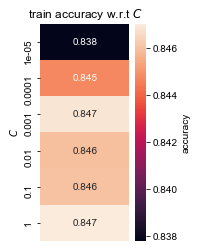

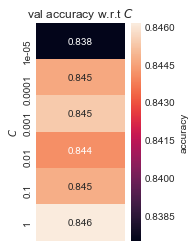

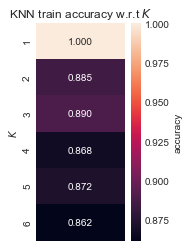

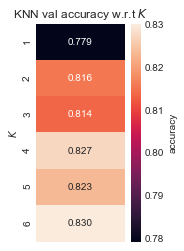

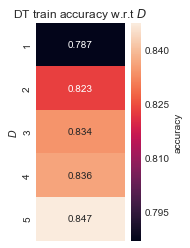

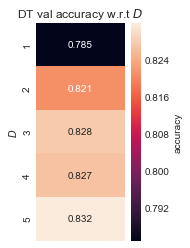

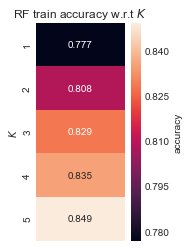

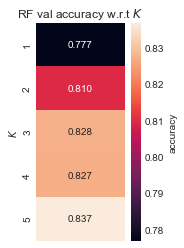

Test Accuracy Average for knn =  0.845
Test Accuracy Average for Random Forest =  0.849
Test Accuracy Average for Boosted Random Forest =  0.8345
Test Accuracy Average for Decision Tree =  0.838
Test Accuracy Average for Boosted Decision Tree =  0.8385
Test Accuracy Average for SVM =  0.8475
Test Accuracy Average for Boosted SVM =  0.848
Partition:  0.5


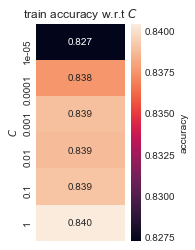

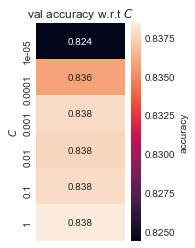

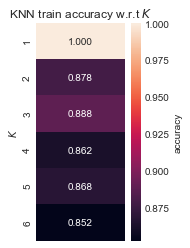

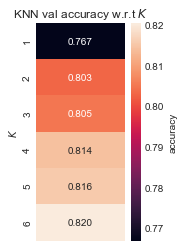

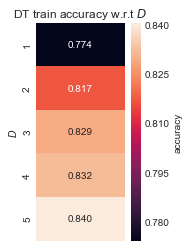

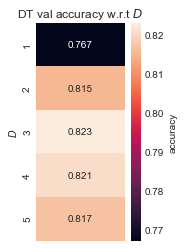

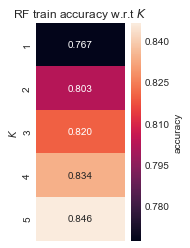

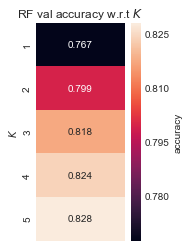

Test Accuracy Average for knn =  0.84
Test Accuracy Average for Random Forest =  0.8474
Test Accuracy Average for Boosted Random Forest =  0.8342
Test Accuracy Average for Decision Tree =  0.8278
Test Accuracy Average for Boosted Decision Tree =  0.8424
Test Accuracy Average for SVM =  0.8528
Test Accuracy Average for Boosted SVM =  0.8548
Partition:  0.2


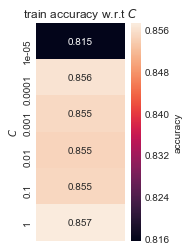

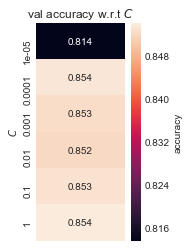

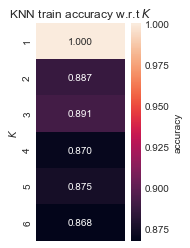

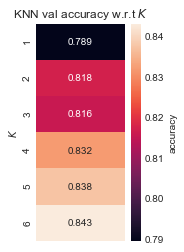

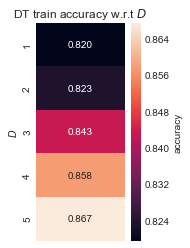

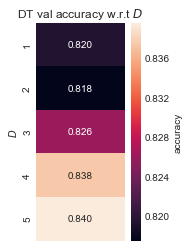

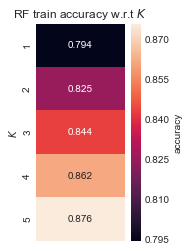

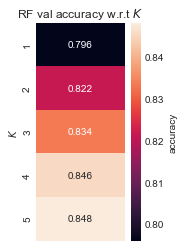

Test Accuracy Average for knn =  0.8335
Test Accuracy Average for Random Forest =  0.83375
Test Accuracy Average for Boosted Random Forest =  0.829625
Test Accuracy Average for Decision Tree =  0.82275
Test Accuracy Average for Boosted Decision Tree =  0.829625
Test Accuracy Average for SVM =  0.844625
Test Accuracy Average for Boosted SVM =  0.84425


In [16]:
partitionVal = [0.8, 0.5, 0.2]
result_table = np.zeros((3,7))
result_table1 = np.zeros((3,7))
result_table2 = np.zeros((3,7))
for i, partition in enumerate(partitionVal):
    print("Partition: ", partition)
    knn_test_acc = []
    rand_forest_test_acc = []
    decision_tree_test_acc = []
    svm_test_acc = []
    
    knn_boosted_test_acc = []
    rand_forest_boosted_test_acc = []
    decision_tree_boosted_test_acc = []
    svm_boosted_test_acc = []
    
    NUM_TRIALS = 1
    for trial in range(NUM_TRIALS):
        np.random.shuffle(data) #shuffle data
        breakNum = int(partition*len(data)) #Find the point where to partition the data
        
        X_train_val = data[:breakNum,:-1]
        Y_train_val = data[:breakNum,-1]
        X_test = data[breakNum:,:-1]
        Y_test = data[breakNum:,-1]
        
        
        test_acc,best_train0,C0 = svm_func()
        svm_test_acc.append(test_acc)#call the svm classifier
        test_acc,best_train1,C1 = knn_classifier()
        knn_test_acc.append(test_acc)#call the knn classifier
        test_acc,best_train2,C2 = decision_Tree()
        decision_tree_test_acc.append(test_acc)#call the Decision Tree classifier
        test_acc,best_train3,C3 = rand_Forest()
        rand_forest_test_acc.append(test_acc)#call the Random Forest classifier
        #knn_boosted_test_acc.append(knn_boost())
        test_acc,best_train4,C4 = svm_func_boost()
        svm_boosted_test_acc.append(test_acc)#call the svm boosted classifier
        test_acc,best_train5,C5 = decision_tree_boost()
        decision_tree_boosted_test_acc.append(test_acc)
        test_acc,best_train6,C6 = random_forest_boost()
        rand_forest_boosted_test_acc.append(test_acc)       
        
    result_table[i, 0] = sum(svm_test_acc)/NUM_TRIALS
    result_table[i, 1] = sum(knn_test_acc)/NUM_TRIALS
    result_table[i, 2] = sum(decision_tree_test_acc)/NUM_TRIALS
    result_table[i, 3] = sum(rand_forest_boosted_test_acc)/NUM_TRIALS
    result_table[i, 4] = sum(svm_boosted_test_acc)/NUM_TRIALS
    result_table[i, 5] = sum(decision_tree_boosted_test_acc)/NUM_TRIALS
    result_table[i, 6] = sum(rand_forest_boosted_test_acc)/NUM_TRIALS
    
    result_table1[i, 0] = best_train0
    result_table1[i, 1] = best_train1
    result_table1[i, 2] = best_train2
    result_table1[i, 3] = best_train3
    result_table1[i, 4] = best_train4
    result_table1[i, 5] = best_train5
    result_table1[i, 6] = best_train6
    
    result_table2[i, 0] = C0
    result_table2[i, 1] = C1
    result_table2[i, 2] = C2
    result_table2[i, 3] = C3
    result_table2[i, 4] = C4
    result_table2[i, 5] = C5
    result_table2[i, 6] = C6
        
    #Average all test accuracies for all 3 trials
    print("Test Accuracy Average for knn = ", sum(knn_test_acc)/NUM_TRIALS)
    #print("Test Accuracy Average for Boosted knn = ", sum(knn_boosted_test_acc)/NUM_TRIALS)
    print("Test Accuracy Average for Random Forest = ", sum(rand_forest_test_acc)/NUM_TRIALS)
    print("Test Accuracy Average for Boosted Random Forest = ", sum(rand_forest_boosted_test_acc)/NUM_TRIALS)
    print("Test Accuracy Average for Decision Tree = ", sum(decision_tree_test_acc)/NUM_TRIALS)
    print("Test Accuracy Average for Boosted Decision Tree = ", sum(decision_tree_boosted_test_acc)/NUM_TRIALS)
    print("Test Accuracy Average for SVM = ", sum(svm_test_acc)/NUM_TRIALS)
    print("Test Accuracy Average for Boosted SVM = ", sum(svm_boosted_test_acc)/NUM_TRIALS)

In [17]:
#y-axis: partition
#x-axis: classifier
print(result_table)
print("############################")
print(result_table1)
print("############################")
print(result_table2)

[[0.8475   0.845    0.838    0.8345   0.848    0.8385   0.8345  ]
 [0.8528   0.84     0.8278   0.8342   0.8548   0.8424   0.8342  ]
 [0.844625 0.8335   0.82275  0.829625 0.84425  0.829625 0.829625]]
############################
[[0.84703125 0.86178125 0.847375   0.849      0.84703125 0.847375
  0.8420625 ]
 [0.84044972 0.85214938 0.82944949 0.84629919 0.84044972 0.82944949
  0.8424997 ]
 [0.85725    0.86775    0.867375   0.87575    0.85725    0.867375
  0.87575   ]]
############################
[[1. 6. 5. 5. 1. 5. 4.]
 [1. 6. 3. 5. 1. 3. 5.]
 [1. 6. 5. 5. 1. 5. 5.]]
